# サポートベクトルマシン

サポートベクトルマシン全般については次を確認してください。
[https://scikit-learn.org/stable/modules/svm.html](https://scikit-learn.org/stable/modules/svm.html)

**データとトークナイザの準備**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# positive, neutral, negative の中から negative なレビューを当てるタスクとして、
# negativeを1に、それ以外のpositive, neutralを0に設定します。
data = pd.read_csv("input/pn_same_judge.csv")
data["label_num"] = data["label"].map({"positive": 0, "neutral": 0, "negative": 1})
train, test = train_test_split(data, test_size=0.1, random_state=0)

In [2]:
import spacy

nlp = spacy.load("ja_core_news_md")

def tokenize(text):
   return [token.lemma_ for token in nlp(text)]

2022-05-26 14:20:41.897041: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-26 14:20:41.897141: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay

## SVC

[sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
を使います。

In [4]:
from sklearn.svm import SVC

In [5]:
pipe = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", SVC())
])

pipe.fit(train["text"], train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f5a9ccc89d0>)),
                ('clf', SVC())])

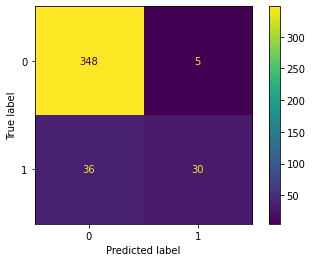

In [6]:
pred = pipe.predict(test["text"])
ConfusionMatrixDisplay.from_predictions(y_true=test["label_num"], y_pred=pred)

In [7]:
# SVC では predict_proba ではなく decision_function を使います
score = pipe.decision_function(test["text"])

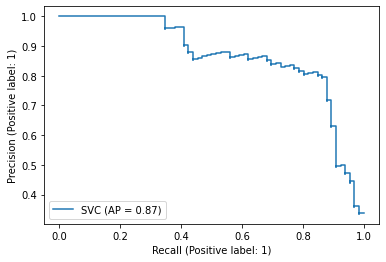

In [8]:
PrecisionRecallDisplay.from_predictions(
    y_true=test["label_num"],
    y_pred=score,
    name="SVC",
)

## 不均衡データに対応する

`class_weight` パラメータで不均衡データに対応できます。

In [9]:
pipe_weight = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", SVC(class_weight="balanced"))
])

pipe_weight.fit(train["text"], train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f5a9ccc89d0>)),
                ('clf', SVC(class_weight='balanced'))])

In [10]:
score_weight = pipe_weight.decision_function(test["text"])

class_weightオプションを付けないモデルと比較します。

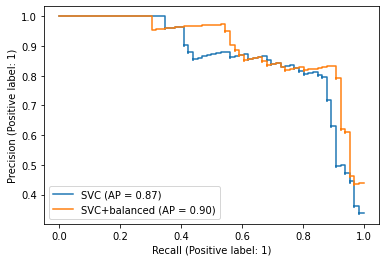

In [11]:
import  matplotlib.pyplot as plt

_, ax = plt.subplots()
for name, pred in [
    ("SVC", score),
    ("SVC+balanced", score_weight),
]:
    PrecisionRecallDisplay.from_predictions(ax=ax, y_true=test["label_num"], y_pred=pred, name=name)